# set up

In [150]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from lib.preprocess import Preprocess, data_augmentation
from sklearn.manifold import TSNE
from sklearn.utils import compute_sample_weight
import shap

pd.set_option('display.max_columns', None)

In [151]:
SEED = 314
datasrc = "data/official/"
data = pd.read_csv(os.path.join(datasrc, "train.csv"), index_col=0)
x_test = pd.read_csv(os.path.join(datasrc, "test.csv"), index_col=0)

train, valid = train_test_split(data, test_size=0.2, random_state=42, stratify=data["health"])
train = train.fillna("Dropped")
valid = valid.fillna("Dropped")

In [152]:
train.head()

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,spc_latin,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
2622,2016-06-10,3,OnCurb,1,1or2,Helpful,NoDamage,Volunteer,RootOtherTrunkOtherBranchOther,American elm,Ulmus americana,MN03,Central Harlem North-Polo Grounds,1,1021200,Manhattan,New York,110,30,70,9
13191,2015-11-04,6,OnCurb,1,Dropped,Dropped,Damage,Volunteer,Dropped,pin oak,Quercus palustris,QN30,Maspeth,4,4052100,Queens,Maspeth,405,15,30,30
16871,2015-07-28,29,OnCurb,1,Dropped,Dropped,Damage,TreesCount Staff,Dropped,red maple,Acer rubrum,SI28,Port Richmond,5,5021300,Staten Island,Staten Island,501,23,61,49
13477,2015-11-11,9,OnCurb,1,Dropped,Dropped,Damage,TreesCount Staff,StonesBranchLights,Callery pear,Pyrus calleryana,MN22,East Village,1,1003800,Manhattan,New York,103,27,66,2
10865,2015-10-28,32,OnCurb,1,Dropped,Dropped,NoDamage,TreesCount Staff,Dropped,pin oak,Quercus palustris,SI11,Charleston-Richmond Valley-Tottenville,5,5022600,Staten Island,Staten Island,503,24,62,51


# details of the pruning process

In [153]:
is_Normalized = False

In [154]:
col = "curb_loc"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

curb_loc,OffsetFromCurb,OnCurb
health,,
0,177,2651
1,723,11878
2,41,517


In [155]:
col = "steward"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

steward,1or2,3or4,4orMore,Dropped
health,,,,
0,592,174,3,2059
1,2552,644,14,9391
2,64,46,2,446


In [156]:
col = "guards"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

guards,Dropped,Harmful,Helpful,Unsure
health,,,,
0,1964,99,629,136
1,9576,413,2178,434
2,408,11,118,21


In [157]:
col = "sidewalk"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

sidewalk,Damage,NoDamage
health,,
0,1358,1470
1,5810,6791
2,257,301


In [158]:
col = "user_type"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

user_type,NYC Parks Staff,TreesCount Staff,Volunteer
health,,,
0,437,779,1612
1,1859,3686,7056
2,97,181,280


In [159]:
col = "spc_common"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

spc_common,'Schubert' chokecherry,American beech,American elm,American hophornbeam,American hornbeam,American linden,Amur cork tree,Amur maackia,Amur maple,Atlantic white cedar,Atlas cedar,Callery pear,Chinese chestnut,Chinese elm,Chinese fringetree,Chinese tree lilac,Cornelian cherry,English oak,European beech,European hornbeam,Himalayan cedar,Japanese hornbeam,Japanese maple,Japanese snowbell,Japanese tree lilac,Japanese zelkova,Kentucky coffeetree,Kentucky yellowwood,London planetree,Norway maple,Norway spruce,Ohio buckeye,Oklahoma redbud,Persian ironwood,Schumard's oak,Shantung maple,Siberian elm,Sophora,Turkish hazelnut,arborvitae,ash,bald cypress,bigtooth aspen,black cherry,black locust,black oak,black walnut,blackgum,blue spruce,bur oak,catalpa,cherry,cockspur hawthorn,common hackberry,crab apple,crepe myrtle,crimson king maple,cucumber magnolia,dawn redwood,eastern cottonwood,eastern hemlock,eastern redbud,eastern redcedar,empress tree,false cypress,flowering dogwood,ginkgo,golden raintree,green ash,hardy rubber tree,hawthorn,hedge maple,holly,honeylocust,horse chestnut,katsura tree,kousa dogwood,littleleaf linden,magnolia,maple,mulberry,northern red oak,pagoda dogwood,paper birch,paperbark maple,pignut hickory,pin oak,pine,pitch pine,pond cypress,purple-leaf plum,quaking aspen,red horse chestnut,red maple,red pine,river birch,sassafras,sawtooth oak,scarlet oak,serviceberry,shingle oak,silver birch,silver linden,silver maple,southern magnolia,spruce,sugar maple,swamp white oak,sweetgum,sycamore maple,tartar maple,tree of heaven,trident maple,tulip-poplar,two-winged silverbell,weeping willow,white ash,white oak,white pine,willow oak
health,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,13.0,1.0,70.0,2.0,3.0,43.0,1.0,5.0,10.0,5.0,5.0,154.0,NaN,24.0,2.0,NaN,3.0,236.0,1.0,2.0,NaN,NaN,2.0,2.0,9.0,248.0,4.0,1.0,333.0,75.0,NaN,3.0,NaN,1.0,4.0,1.0,6.0,86.0,2.0,NaN,1.0,3.0,1.0,1.0,5.0,1.0,4.0,3.0,NaN,1.0,1.0,177.0,3.0,1.0,2.0,NaN,9.0,NaN,8.0,2.0,1.0,13.0,7.0,NaN,1.0,1.0,93.0,3.0,168.0,1.0,7.0,1.0,1.0,149.0,1.0,3.0,2.0,216.0,1.0,25.0,NaN,14.0,NaN,1.0,1.0,NaN,255.0,NaN,2.0,NaN,33.0,1.0,4.0,31.0,1.0,1.0,1.0,7.0,5.0,1.0,4.0,2.0,28.0,64.0,NaN,3.0,2.0,26.0,31.0,4.0,1.0,1.0,1.0,7.0,1.0,4.0,6.0,6.0,2.0,3.0
1,66.0,6.0,245.0,17.0,13.0,233.0,9.0,22.0,30.0,22.0,5.0,659.0,3.0,120.0,9.0,5.0,6.0,747.0,1.0,21.0,1.0,2.0,11.0,5.0,67.0,836.0,34.0,1.0,1447.0,412.0,3.0,9.0,4.0,7.0,25.0,7.0,58.0,323.0,3.0,4.0,16.0,7.0,1.0,3.0,33.0,11.0,6.0,8.0,7.0,13.0,22.0,1129.0,2.0,9.0,69.0,8.0,95.0,4.0,52.0,13.0,2.0,77.0,18.0,7.0,5.0,14.0,305.0,44.0,687.0,16.0,24.0,28.0,5.0,647.0,9.0,7.0,10.0,831.0,4.0,106.0,3.0,54.0,3.0,2.0,4.0,3.0,1402.0,2.0,14.0,1.0,120.0,4.0,8.0,172.0,4.0,8.0,11.0,33.0,20.0,18.0,12.0,3.0,124.0,268.0,4.0,9.0,38.0,113.0,131.0,25.0,8.0,7.0,6.0,10.0,5.0,8.0,21.0,19.0,5.0,47.0
2,NaN,NaN,5.0,NaN,NaN,3.0,2.0,1.0,3.0,NaN,NaN,42.0,NaN,2.0,2.0,NaN,1.0,48.0,1.0,NaN,NaN,NaN,2.0,1.0,3.0,61.0,1.0,NaN,37.0,30.0,NaN,NaN,NaN,NaN,2.0,NaN,1.0,19.0,1.0,1.0,2.0,2.0,1.0,NaN,3.0,NaN,2.0,1.0,NaN,1.0,NaN,56.0,NaN,NaN,NaN,1.0,3.0,NaN,5.0,NaN,1.0,5.0,NaN,NaN,NaN,1.0,13.0,1.0,30.0,NaN,1.0,1.0,1.0,28.0,NaN,NaN,1.0,25.0,1.0,4.0,NaN,2.0,2.0,NaN,2.0,NaN,35.0,2.0,1.0,NaN,4.0,NaN,NaN,9.0,NaN,1.0,1.0,NaN,1.0,2.0,1.0,4.0,2.0,6.0,NaN,NaN,2.0,5.0,11.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0


In [160]:
col = "nta"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

nta,BK09,BK17,BK19,BK21,BK23,BK25,BK26,BK27,BK28,BK29,BK30,BK31,BK32,BK33,BK34,BK35,BK37,BK38,BK40,BK41,BK42,BK43,BK44,BK45,BK46,BK50,BK58,BK60,BK61,BK63,BK64,BK68,BK69,BK72,BK73,BK75,BK76,BK77,BK78,BK79,BK81,BK82,BK83,BK85,BK88,BK90,BK91,BK93,BK95,BK96,BX01,BX03,BX05,BX06,BX07,BX08,BX09,BX10,BX13,BX14,BX17,BX22,BX26,BX27,BX28,BX29,BX30,BX31,BX33,BX34,BX35,BX36,BX37,BX39,BX40,BX41,BX43,BX44,BX46,BX49,BX52,BX55,BX59,BX62,BX63,BX75,MN01,MN03,MN04,MN06,MN09,MN11,MN12,MN13,MN14,MN15,MN17,MN19,MN20,MN21,MN22,MN23,MN24,MN25,MN27,MN28,MN31,MN32,MN33,MN34,MN35,MN36,MN40,QN01,QN02,QN03,QN05,QN06,QN07,QN08,QN10,QN12,QN15,QN17,QN18,QN19,QN20,QN21,QN22,QN23,QN25,QN26,QN27,QN28,QN29,QN30,QN31,QN33,QN34,QN35,QN37,QN38,QN41,QN42,QN43,QN44,QN45,QN46,QN47,QN48,QN49,QN50,QN51,QN52,QN53,QN54,QN55,QN56,QN57,QN60,QN61,QN62,QN63,QN66,QN68,QN70,QN71,QN72,QN76,SI01,SI05,SI07,SI08,SI11,SI12,SI14,SI22,SI24,SI25,SI28,SI32,SI35,SI36,SI37,SI45,SI48,SI54
health,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,12.0,18.0,2.0,6.0,3.0,10.0,4.0,NaN,16.0,6.0,3.0,38.0,21.0,24.0,11.0,24.0,32.0,14.0,8.0,3.0,31.0,9.0,8.0,48.0,16.0,5.0,20.0,1.0,32.0,10.0,4.0,16.0,19.0,24.0,12.0,30.0,18.0,15.0,6.0,12.0,7.0,38.0,21.0,24.0,14.0,11.0,6.0,NaN,2.0,7.0,8.0,10.0,2.0,7.0,3.0,3.0,31.0,17.0,10.0,4.0,5.0,6.0,3.0,26.0,7.0,6.0,1.0,15.0,3.0,5.0,6.0,15.0,20.0,6.0,1.0,1.0,11.0,7.0,2.0,11.0,17.0,8.0,12.0,18.0,3.0,4.0,6.0,14.0,12.0,2.0,11.0,9.0,44.0,6.0,10.0,14.0,3.0,10.0,NaN,1.0,2.0,15.0,20.0,17.0,10.0,8.0,11.0,10.0,9.0,15.0,4.0,11.0,37.0,15.0,4.0,32.0,25.0,16.0,6.0,17.0,15.0,6.0,24.0,38.0,4.0,28.0,25.0,35.0,13.0,17.0,8.0,NaN,8.0,16.0,21.0,20.0,22.0,14.0,12.0,6.0,21.0,18.0,4.0,31.0,28.0,25.0,25.0,48.0,9.0,23.0,45.0,11.0,33.0,13.0,6.0,9.0,28.0,29.0,24.0,15.0,8.0,6.0,8.0,17.0,NaN,9.0,7.0,10.0,11.0,51.0,21.0,29.0,20.0,42.0,22.0,8.0,22.0,36.0,23.0,31.0,41.0,26.0,41.0,11.0,14.0,24.0,52.0
1,72.0,100.0,13.0,29.0,11.0,49.0,12.0,1.0,53.0,34.0,21.0,122.0,97.0,122.0,35.0,104.0,131.0,57.0,26.0,30.0,140.0,65.0,57.0,188.0,43.0,33.0,92.0,11.0,107.0,51.0,27.0,44.0,81.0,61.0,68.0,134.0,87.0,63.0,29.0,74.0,40.0,207.0,97.0,75.0,80.0,79.0,15.0,14.0,24.0,41.0,50.0,53.0,23.0,31.0,22.0,31.0,90.0,75.0,43.0,45.0,10.0,38.0,33.0,73.0,33.0,27.0,11.0,64.0,15.0,54.0,45.0,87.0,22.0,31.0,13.0,3.0,37.0,30.0,14.0,41.0,111.0,30.0,58.0,50.0,13.0,31.0,50.0,48.0,47.0,18.0,62.0,47.0,182.0,20.0,54.0,63.0,1.0,54.0,NaN,3.0,16.0,69.0,69.0,99.0,38.0,49.0,45.0,66.0,38.0,66.0,29.0,34.0,180.0,74.0,41.0,117.0,112.0,68.0,38.0,91.0,69.0,38.0,140.0,174.0,18.0,75.0,126.0,135.0,45.0,75.0,35.0,8.0,43.0,70.0,55.0,61.0,92.0,52.0,63.0,50.0,107.0,108.0,38.0,132.0,112.0,102.0,139.0,168.0,43.0,72.0,143.0,38.0,97.0,33.0,21.0,55.0,108.0,67.0,112.0,69.0,48.0,26.0,38.0,89.0,4.0,48.0,13.0,73.0,47.0,186.0,174.0,121.0,75.0,225.0,90.0,55.0,101.0,97.0,120.0,104.0,196.0,126.0,119.0,105.0,85.0,146.0,231.0
2,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,2.0,NaN,3.0,6.0,7.0,2.0,2.0,1.0,8.0,3.0,NaN,3.0,1.0,4.0,2.0,6.0,3.0,1.0,3.0,2.0,2.0,1.0,1.0,NaN,3.0,1.0,NaN,3.0,2.0,4.0,NaN,3.0,3.0,15.0,5.0,4.0,4.0,6.0,2.0,1.0,2.0,NaN,2.0,4.0,1.0,1.0,2.0,1.0,7.0,1.0,2.0,3.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,6.0,2.0,NaN,1.0,NaN,2.0,NaN,1.0,1.0,2.0,1.0,NaN,2.0,2.0,2.0,3.0,4.0,NaN,1.0,NaN,2.0,1.0,1.0,1.0,1.0,6.0,1.0,4.0,3.0,1.0,1.0,1.0,1.0,NaN,4.0,5.0,3.0,NaN,3.0,1.0,2.0,1.0,5.0,NaN,1.0,11.0,6.0,NaN,8.0,8.0,3.0,2.0,3.0,1.0,1.0,7.0,10.0,3.0,8.0,6.0,7.0,4.0,3.0,1.0,NaN,3.0,2.0,NaN,4.0,4.0,1.0,8.0,NaN,3.0,3.0,2.0,5.0,8.0,9.0,10.0,12.0,2.0,3.0,9.0,NaN,3.0,NaN,1.0,2.0,6.0,3.0,6.0,NaN,4.0,2.0,NaN,3.0,NaN,NaN,1.0,2.0,1.0,10.0,7.0,5.0,4.0,12.0,2.0,1.0,3.0,6.0,7.0,2.0,10.0,4.0,10.0,2.0,5.0,7.0,13.0


In [161]:
col = "borocode"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

borocode,1,2,3,4,5
health,,,,,
0,311,314,721,968,514
1,1447,1437,3246,4115,2356
2,60,57,128,203,110


In [162]:
col = "boro_ct"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

boro_ct,1000202,1000800,1001402,1001501,1001600,1002100,1002601,1002602,1002800,1002900,1003300,1003700,1003800,1003900,1004700,1004800,1006100,1006400,1006700,1006800,1007100,1007300,1007400,1007500,1007700,1007900,1008200,1008601,1008800,1009300,1009800,1009900,1010400,1010601,1010602,1010800,1011201,1011800,1012000,1012100,1012200,1012400,1012500,1012600,1012700,1012800,1012900,1013000,1013300,1013400,1013500,1013600,1013800,1013900,1014200,1014300,1014401,1014402,1014700,1014801,1014802,1014900,1015001,1015002,1015300,1015400,1015500,1015601,1015602,1015700,1015801,1016001,1016100,1016300,1016400,1016500,1016600,1016700,1016800,1016900,1017100,1017200,1017300,1017500,1017700,1017800,1018000,1018400,1018500,1018700,1018800,1018900,1019000,1019100,1019200,1019300,1019500,1019800,1019900,1020102,1020500,1020600,1020701,1020800,1021200,1021703,1022000,1022102,1022301,1022500,1022700,1022900,1023100,1023200,1023300,1023700,1024100,1024200,1024301,1024500,1025300,1025500,1026300,1026500,1026900,1027300,1027700,1027900,1028700,1029300,1029500,1029900,1030700,1031100,1031703,1031704,2000200,2000400,2001600,2001900,2002000,2002400,2002500,2003300,2003900,2004300,2004600,2004800,2005001,2005002,2005200,2005400,2006300,2006700,2006900,2007300,2007400,2007500,2007700,2007800,2007900,2008300,2008400,2008700,2009000,2009200,2009300,2009600,2009800,2011502,2011700,2011900,2012102,2012901,2013100,2013200,2013300,2013500,2014100,2014400,2014900,2015300,2016000,2016100,2016200,2016300,2016500,2016600,2016700,2017100,2017300,2017500,2017702,2018102,2018400,2018500,2018900,2019400,2019700,2019900,2020000,2020100,2020200,2020400,2020601,2021002,2021200,2021302,2021502,2021602,2021700,2021800,2021900,2022403,2022702,2022703,2022800,2022901,2023301,2023702,2023704,2023900,2024000,2024501,2024600,2024700,2024800,2025000,2025100,2025600,2026400,2026602,2026900,2027401,2027402,2027900,2028100,2028500,2028700,2028800,2029500,2029600,2030000,2031000,2031200,2031400,2032300,2032400,2032600,2032800,2033000,2033400,2033500,2033700,2033800,2034300,2034400,2034500,2034800,2035000,2035800,2036000,2036901,2036902,2037000,2037200,2037800,2038000,2038200,2038500,2038600,2038800,2038900,2039300,2039400,2039500,2039700,2039800,2039901,2039902,2040100,2040501,2040502,2040900,2041300,2041400,2041800,2041900,2042500,2042600,2042800,2043100,2043400,2043500,2044400,2044901,2045101,2045600,2045800,2046000,2046201,2046202,2048400,2051600,3000100,3000301,3000502,3000700,3000900,3001100,3001300,3001800,3002000,3002100,3002200,3003100,3003300,3004100,3004400,3004500,3004600,3005100,3005201,3005300,3005601,3005900,3006200,3006300,3006400,3006500,3006700,3006900,3007100,3007200,3007500,3007800,3008800,3009600,3010100,3011200,3011600,3012700,3013100,3013400,3013600,3013700,3013800,3014500,3014900,3015100,3015200,3015300,3015700,3015900,3016000,3016600,3016700,3017100,3017500,3017700,3018000,3018100,3018200,3018501,3019000,3019100,3019200,3019300,3019400,3019500,3019700,3019800,3019900,3020100,3020200,3020300,3020400,3021200,3021300,3021500,3021600,3021800,3021900,3022000,3023200,3023300,3023400,3023500,3023600,3023800,3024200,3024300,3024500,3024700,3025000,3025100,3025300,3025400,3026100,3026200,3026300,3026400,3026500,3026600,3026700,3026800,3027100,3027300,3027400,3027700,3027900,3028100,3028501,3028600,3028700,3029300,3029500,3029600,3030200,3030400,3030900,3031500,3031701,3031702,3031900,3032100,3032300,3032800,3033300,3033700,3034700,3034800,3035100,3035200,3035400,3035900,3036200,3036501,3036502,3036600,3036900,3037000,3037100,3037300,3037401,3037500,3037700,3037900,3038300,3038700,3038900,3039100,3039600,3039700,3039800,3040100,3040400,3040600,3041401,3041402,3041700,3041800,3042300,3042400,3042700,3042900,3043300,3043500,3043700,3043800,3043900,3044000,3044100,3044300,3044400,3044500,3044900,3045000,3045600,3045800,3046202,3046400,3047000,3047400,3047700,3048000,3048200,3048400,3049000,3049300,3049400,3049500,3049600,3050100,3050300,3050400,3050500,3050600,3050700,

In [163]:
col = "zip_city"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

zip_city,Arverne,Astoria,Bayside,Bellerose,Bronx,Brooklyn,Cambria Heights,Central Park,College Point,Corona,East Elmhurst,Elmhurst,Far Rockaway,Floral Park,Flushing,Forest Hills,Fresh Meadows,Glen Oaks,Hollis,Howard Beach,Jackson Heights,Jamaica,Kew Gardens,Little Neck,Long Island City,Maspeth,Middle Village,New York,Oakland Gardens,Ozone Park,Queens Village,Rego Park,Richmond Hill,Ridgewood,Rockaway Park,Rosedale,Saint Albans,South Ozone Park,South Richmond Hill,Springfield Gardens,Staten Island,Sunnyside,Whitestone,Woodhaven,Woodside
health,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.0,22.0,36.0,20.0,314.0,721.0,14.0,1.0,21.0,7.0,16.0,24.0,27.0,5.0,100.0,35.0,30.0,20.0,9.0,24.0,10.0,83.0,11.0,25.0,18.0,24.0,30.0,310.0,43.0,32.0,24.0,7.0,11.0,53.0,13.0,26.0,6.0,17.0,10.0,36.0,514.0,4.0,46.0,6.0,18.0
1,32.0,108.0,124.0,89.0,1437.0,3246.0,53.0,15.0,82.0,42.0,98.0,63.0,159.0,22.0,365.0,164.0,151.0,80.0,45.0,112.0,32.0,425.0,49.0,139.0,72.0,71.0,128.0,1432.0,182.0,74.0,96.0,27.0,66.0,200.0,56.0,127.0,45.0,82.0,29.0,166.0,2356.0,19.0,150.0,20.0,71.0
2,1.0,2.0,10.0,7.0,57.0,128.0,1.0,2.0,7.0,1.0,3.0,NaN,7.0,2.0,17.0,9.0,4.0,7.0,1.0,6.0,2.0,19.0,NaN,10.0,3.0,5.0,7.0,58.0,8.0,3.0,9.0,4.0,2.0,14.0,1.0,9.0,4.0,6.0,NaN,5.0,110.0,NaN,6.0,1.0,NaN


In [164]:
col = "cb_num"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

cb_num,101,102,103,104,105,106,107,108,109,110,111,112,201,202,203,204,205,206,207,208,209,210,211,212,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,401,402,403,404,405,406,407,408,409,410,411,412,413,414,501,502,503
health,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,33.0,19.0,20.0,20.0,3.0,11.0,63.0,58.0,16.0,21.0,26.0,21.0,13.0,28.0,12.0,9.0,16.0,19.0,10.0,19.0,53.0,52.0,43.0,40.0,69.0,56.0,58.0,18.0,83.0,58.0,39.0,20.0,21.0,41.0,22.0,38.0,10.0,39.0,41.0,19.0,16.0,73.0,27.0,34.0,24.0,35.0,108.0,42.0,136.0,65.0,30.0,81.0,127.0,60.0,154.0,45.0,161.0,120.0,233.0
1,155.0,83.0,102.0,83.0,1.0,57.0,274.0,291.0,89.0,89.0,110.0,113.0,91.0,80.0,91.0,87.0,103.0,84.0,53.0,98.0,214.0,229.0,138.0,169.0,335.0,245.0,250.0,71.0,391.0,256.0,157.0,85.0,78.0,142.0,88.0,161.0,49.0,203.0,224.0,114.0,84.0,313.0,146.0,145.0,119.0,107.0,398.0,191.0,462.0,371.0,145.0,287.0,511.0,339.0,647.0,247.0,722.0,529.0,1105.0
2,8.0,4.0,3.0,4.0,1.0,3.0,11.0,14.0,2.0,3.0,6.0,1.0,NaN,2.0,3.0,3.0,3.0,3.0,2.0,2.0,13.0,4.0,12.0,10.0,9.0,4.0,5.0,4.0,25.0,11.0,9.0,2.0,2.0,10.0,3.0,10.0,2.0,5.0,6.0,6.0,5.0,10.0,3.0,4.0,5.0,1.0,25.0,13.0,22.0,12.0,3.0,15.0,30.0,17.0,44.0,9.0,22.0,29.0,59.0


In [165]:
col = "st_senate"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

st_senate,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36
health,,,,,,,,,,,,,,,,,,,,,,,,,,
0,141,276,55,55,107,235,99,59,86,97,61,75,114,147,397,141,106,51,70,47,71,46,59,45,140,48
1,639,1159,242,263,545,927,340,315,421,487,265,348,426,652,1831,610,472,235,331,267,295,251,315,187,598,180
2,39,68,9,8,20,46,13,14,17,29,11,14,17,24,93,17,12,13,15,9,8,5,11,9,25,12


In [166]:
col = "st_assem"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

st_assem,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87
health,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,87.0,60.0,94.0,98.0,71.0,71.0,57.0,55.0,75.0,33.0,62.0,25.0,19.0,24.0,40.0,26.0,21.0,50.0,28.0,21.0,26.0,47.0,28.0,24.0,18.0,31.0,5.0,56.0,46.0,51.0,25.0,35.0,22.0,46.0,59.0,15.0,57.0,55.0,120.0,203.0,97.0,120.0,31.0,37.0,24.0,24.0,45.0,29.0,22.0,7.0,41.0,11.0,20.0,20.0,17.0,11.0,21.0,32.0,36.0,50.0,27.0,35.0,27.0,12.0,46.0
1,362.0,287.0,361.0,424.0,326.0,323.0,316.0,187.0,308.0,162.0,262.0,104.0,79.0,119.0,199.0,64.0,71.0,161.0,160.0,125.0,90.0,205.0,143.0,108.0,68.0,132.0,30.0,254.0,171.0,273.0,130.0,158.0,129.0,219.0,218.0,69.0,242.0,256.0,492.0,933.0,502.0,495.0,158.0,155.0,126.0,106.0,197.0,136.0,71.0,67.0,200.0,57.0,72.0,102.0,147.0,52.0,138.0,136.0,146.0,224.0,124.0,121.0,120.0,83.0,146.0
2,14.0,10.0,18.0,25.0,16.0,18.0,14.0,10.0,20.0,9.0,22.0,2.0,4.0,2.0,9.0,4.0,1.0,5.0,7.0,5.0,3.0,8.0,3.0,6.0,1.0,7.0,4.0,5.0,10.0,7.0,7.0,7.0,4.0,4.0,6.0,3.0,7.0,20.0,15.0,51.0,18.0,30.0,4.0,10.0,6.0,6.0,8.0,4.0,2.0,NaN,10.0,2.0,5.0,3.0,4.0,1.0,3.0,10.0,5.0,4.0,9.0,2.0,4.0,4.0,11.0


In [167]:
col = "cncldist"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

cncldist,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51
health,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,43,12,39,55,14,47,31,24,39,15,40,36,68,17,30,14,48,53,137,65,22,25,127,62,37,31,44,49,58,108,110,86,78,28,68,61,48,39,60,15,30,52,48,42,29,66,32,32,147,150,217
1,199,64,164,243,88,223,148,108,165,94,158,156,305,120,123,112,218,196,526,196,110,132,526,358,116,140,256,218,273,386,514,328,347,183,259,231,223,161,263,94,175,244,163,162,154,282,145,196,654,679,1023
2,10,2,8,12,4,12,2,5,5,1,5,10,13,2,6,4,4,12,33,5,5,2,37,10,2,3,12,15,14,24,27,11,6,11,6,5,10,11,11,6,5,19,9,7,7,7,6,5,18,38,54


In [168]:
col = "nta_name"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

nta_name,Allerton-Pelham Gardens,Annadale-Huguenot-Prince's Bay-Eltingville,Arden Heights,Astoria,Auburndale,Baisley Park,Bath Beach,Battery Park City-Lower Manhattan,Bay Ridge,Bayside-Bayside Hills,Bedford,Bedford Park-Fordham North,Bellerose,Belmont,Bensonhurst East,Bensonhurst West,Borough Park,Breezy Point-Belle Harbor-Rockaway Park-Broad Channel,Briarwood-Jamaica Hills,Brighton Beach,Bronxdale,Brooklyn Heights-Cobble Hill,Brownsville,Bushwick North,Bushwick South,Cambria Heights,Canarsie,Carroll Gardens-Columbia Street-Red Hook,Central Harlem North-Polo Grounds,Central Harlem South,Charleston-Richmond Valley-Tottenville,Chinatown,Claremont-Bathgate,Clinton,Clinton Hill,Co-op City,College Point,Corona,Crotona Park East,Crown Heights North,Crown Heights South,Cypress Hills-City Line,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,Douglas Manor-Douglaston-Little Neck,Dyker Heights,East Concourse-Concourse Village,East Elmhurst,East Flatbush-Farragut,East Flushing,East Harlem North,East Harlem South,East New York,East New York (Pennsylvania Ave),East Tremont,East Village,East Williamsburg,Eastchester-Edenwald-Baychester,Elmhurst,Elmhurst-Maspeth,Erasmus,Far Rockaway-Bayswater,Flatbush,Flatlands,Flushing,Fordham South,Forest Hills,Fort Greene,Fresh Meadows-Utopia,Ft. Totten-Bay Terrace-Clearview,Georgetown-Marine Park-Bergen Beach-Mill Basin,Glen Oaks-Floral Park-New Hyde Park,Glendale,Gramercy,Grasmere-Arrochar-Ft. Wadsworth,Gravesend,Great Kills,Greenpoint,Grymes Hill-Clifton-Fox Hills,Hamilton Heights,Hammels-Arverne-Edgemere,Highbridge,Hollis,Homecrest,Hudson Yards-Chelsea-Flatiron-Union Square,Hunters Point-Sunnyside-West Maspeth,Hunts Point,Jackson Heights,Jamaica,Jamaica Estates-Holliswood,Kensington-Ocean Parkway,Kew Gardens,Kew Gardens Hills,Kingsbridge Heights,Laurelton,Lenox Hill-Roosevelt Island,Lincoln Square,Lindenwood-Howard Beach,Longwood,Lower East Side,Madison,Manhattanville,Marble Hill-Inwood,Mariner's Harbor-Arlington-Port Ivory-Graniteville,Maspeth,Melrose South-Mott Haven North,Middle Village,Midtown-Midtown South,Midwood,Morningside Heights,Morrisania-Melrose,Mott Haven-Port Morris,Mount Hope,Murray Hill,Murray Hill-Kips Bay,New Brighton-Silver Lake,New Dorp-Midland Beach,New Springville-Bloomfield-Travis,North Corona,North Riverdale-Fieldston-Riverdale,North Side-South Side,Norwood,Oakland Gardens,Oakwood-Oakwood Beach,Ocean Hill,Ocean Parkway South,Old Astoria,Old Town-Dongan Hills-South Beach,Ozone Park,Park Slope-Gowanus,Parkchester,Pelham Bay-Country Club-City Island,Pelham Parkway,Pomonok-Flushing Heights-Hillcrest,Port Richmond,Prospect Heights,Prospect Lefferts Gardens-Wingate,Queens Village,Queensboro Hill,Queensbridge-Ravenswood-Long Island City,Rego Park,Richmond Hill,Ridgewood,Rosedale,Rossville-Woodrow,Rugby-Remsen Village,Schuylerville-Throgs Neck-Edgewater Park,Seagate-Coney Island,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,SoHo-TriBeCa-Civic Center-Little Italy,Soundview-Bruckner,Soundview-Castle Hill-Clason Point-Harding Park,South Jamaica,South Ozone Park,Springfield Gardens North,Springfield Gardens South-Brookville,Spuyten Duyvil-Kingsbridge,St. Albans,Stapleton-Rosebank,Starrett City,Steinway,Stuyvesant Heights,Sunset Park East,Sunset Park West,Todt Hill-Emerson Hill-Heartland Village-Lighthouse Hill,Turtle Bay-East Midtown,University Heights-Morris Heights,Upper East Side-Carnegie Hill,Upper West Side,Van Cortlandt Village,Van Nest-Morris Park-Westchester Square,Washington Heights North,Washington Heights South,West Brighton,West Concourse,West Farms-Bronx River,West New Brighton-New Brighton-St. George,West Village,Westchester-Unionport,Westerleigh,Whitestone,Williamsbridge-Olinville,Williamsburg,Windsor Terrace,Woodhaven,Woodlawn-Wakefield,Woodside,Yorkville
health,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,15.0,51.0,24.0,9.0,23.0,1

In [169]:
col = "boroname"
train.groupby("health")[col].value_counts(normalize=is_Normalized).unstack()

boroname,Bronx,Brooklyn,Manhattan,Queens,Staten Island
health,,,,,
0,314,721,311,968,514
1,1437,3246,1447,4115,2356
2,57,128,60,203,110


# pruning col unique

In [170]:
columns = train.columns
ignore_list = ["created_at", "tree_dbh", "spc_latin", "nta_name", "borocode", "health", "problems"]
columns = [c for c in columns if c not in ignore_list]

In [171]:
count_threshold = 10

for col in columns:
    train[col] = train[col].astype(str)
    valid[col] = valid[col].astype(str)
    df = train.groupby("health")[col].value_counts(normalize=False).unstack()
    for uniq in df:
        for health, count in df[uniq].to_dict().items():
            if count < count_threshold:
                # print(col, uniq, health, count)
                train.loc[train[col]==uniq, col] = "other"
                valid.loc[valid[col]==uniq, col] = "other"

# build model

In [172]:
def mean_f1score(preds:np.ndarray,eval_data: lgb.Dataset):
    y_true = eval_data.get_label()
    weight = eval_data.get_weight()
    preds = preds.reshape(len(np.unique(y_true)), -1)
    preds = preds.argmax(axis = 0)
    f1 = f1_score(y_true,preds,average='macro',sample_weight=weight)
    return 'f1',f1,True

In [173]:
ignore_columns = [
    "created_at",
    "nta_name",
    "boro_ct",
    "spc_latin",
    "health",
    "borocode",
    "health",
]
# get object columns
object_columns = [col for col in train.select_dtypes(include=["object"]).columns.tolist() if col not in ignore_columns]
config = {
    "object_columns": object_columns,
    "is_target_encode": False,
}

In [174]:
object_columns

['curb_loc',
 'steward',
 'guards',
 'sidewalk',
 'user_type',
 'problems',
 'spc_common',
 'nta',
 'boroname',
 'zip_city',
 'cb_num',
 'st_senate',
 'st_assem',
 'cncldist']

In [ ]:
preprocess = Preprocess(config)
x_train, y_train = train.drop(["health"], axis=1), train["health"]
x_valid, y_valid = valid.drop(["health"], axis=1), valid["health"]
x_train = preprocess.fit_transform(x_train, y_train)
x_valid = preprocess.transform(x_valid)

x_train = pd.DataFrame(x_train, columns=preprocess.get_feature_names_out(), index=train.index)
x_valid = pd.DataFrame(x_valid, columns=preprocess.get_feature_names_out(), index=valid.index)

In [ ]:
lgb_train = lgb.Dataset(x_train, y_train)#, categorical_feature=object_columns)

model = lgb.train(
    {
        "objective": "multiclass",
        "num_class": 3,
    },
    lgb_train,
    valid_sets=[lgb_train],
    num_boost_round=1000,
    feval=mean_f1score
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 15987, number of used features: 39
[LightGBM] [Info] Start training from score -1.732206
[LightGBM] [Info] Start training from score -0.238000
[LightGBM] [Info] Start training from score -3.355172
[1]	training's multi_logloss: 0.605698	training's f1: 0.293853
[2]	training's multi_logloss: 0.601134	training's f1: 0.293853
[3]	training's multi_logloss: 0.59698	training's f1: 0.293853
[4]	training's multi_logloss: 0.593158	training's f1: 0.293853
[5]	training's multi_logloss: 0.589628	training's f1: 0.293853
[6]	training's multi_logloss: 0.586321	training's f1: 0.293853
[7]	training's multi_logloss: 0.583028	training's f1: 0.293853
[8]	training's multi_logloss: 0.579994	tra

In [ ]:
y_pred = model.predict(x_valid)
f1_score(y_valid, y_pred.argmax(axis=1), average='macro')

0.3243253300917449

In [ ]:
y_valid.value_counts(normalize=True)

1    0.788091
0    0.176883
2    0.035026
Name: health, dtype: float64

In [ ]:
pd.Series(y_pred.argmax(axis=1)).value_counts(normalize=True)

1    0.963473
0    0.034276
2    0.002252
dtype: float64

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid)

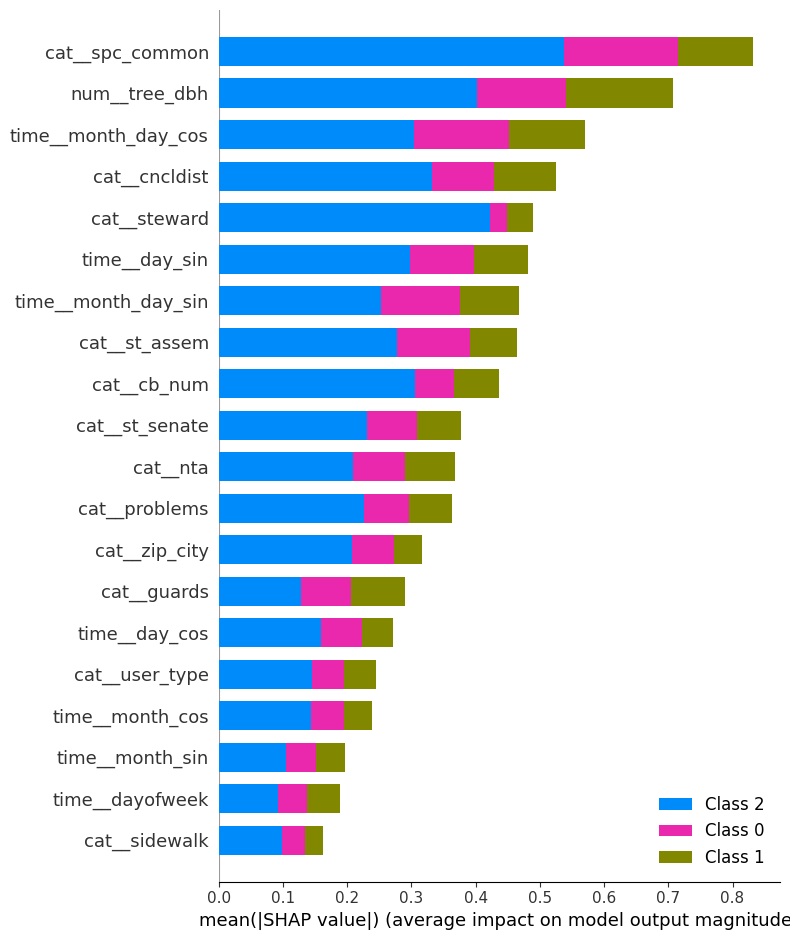

In [ ]:
shap.summary_plot(shap_values, x_valid, plot_type="bar")